In [1]:
import csv
from matplotlib import pyplot as plt
import numpy as np

reshape_size = (48,48)
def GetData(filename):
    X = []
    Y = []
    with open(filename) as csv_file:
        f = 0
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if f == 0 :
                print(row)
                f = 1
            elif f == 1:
                pixels = np.fromstring(row[1], dtype=int, sep=' ')
                pixels = pixels.reshape( reshape_size )
                emotion = int(row[0])

                X.append(pixels)
                Y.append(emotion)
    return [X,Y]

In [2]:
[train_X, train_Y] = GetData('../input/train.csv')
train_X = np.array(train_X)
train_Y = np.array(train_Y)

print('Train data shape:',train_X.shape, train_Y.shape)

['emotion', 'pixels']
Train data shape: (28709, 48, 48) (28709,)


In [3]:
[validation_X, validation_Y] = GetData('../input/val.csv')
validation_X = np.array(validation_X)
validation_Y = np.array(validation_Y)

print('Validation data shape:',validation_X.shape, validation_Y.shape)

['emotion', 'pixels']
Validation data shape: (3589, 48, 48) (3589,)


In [4]:
[test_X, test_Y] = GetData('../input/test.csv')
test_X = np.array(test_X)
test_Y = np.array(test_Y)

print('Test data shape:',test_X.shape, test_Y.shape)

['emotion', 'pixels']
Test data shape: (3589, 48, 48) (3589,)


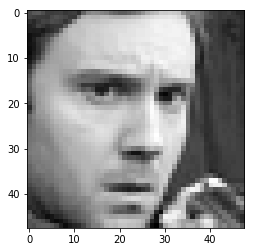

In [5]:
plt.figure(0)
plt.imshow(train_X[0], cmap = 'gray')
plt.show()

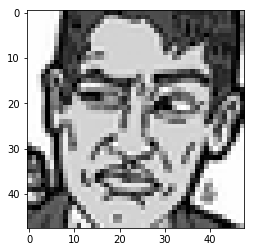

In [6]:
plt.figure(1)
plt.imshow(validation_X[0], cmap = 'gray')
plt.show()

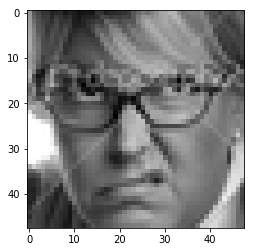

In [7]:
plt.figure(2)
plt.imshow(test_X[0], cmap = 'gray')
plt.show()

In [8]:
def ChangeTo4D(data):
    ip_shape = data.shape
    #ip_shape = (1,)+ip_shape
    ip_shape = (ip_shape[0],1,ip_shape[1],ip_shape[2])
    #ip_shape = ip_shape +(1,)
    return data.reshape(ip_shape)

In [9]:
train_X_4d = ChangeTo4D(train_X)
validation_X_4d = ChangeTo4D(validation_X)
test_X_4d = ChangeTo4D(test_X)

In [10]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [11]:
test_Y_one_hot_encoding = keras.utils.to_categorical(test_Y);
train_Y_one_hot_encoding = keras.utils.to_categorical(train_Y);
validation_Y_one_hot_encoding = keras.utils.to_categorical(validation_Y);

In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.0,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(train_X_4d)

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:923: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28709, 1, 48, 48) (48 channels).
  ' channels).')


In [13]:
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [14]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(1,48,48)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())


model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))


model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(BatchNormalization())


model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64, activation=swish_activation))
#model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(7 , activation='sigmoid'))
model.add(Dense(7 , activation='softplus'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam' ,
              metrics=['categorical_accuracy'])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 48, 48)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 48, 48)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 48, 48)        192       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 24, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 24, 24)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)    

In [15]:
batch_size = 128
epochs = 15
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                              factor=0.1, 
                              epsilon=0.0001, 
                              patience=1, verbose=1)

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [16]:
import scipy.ndimage

train_X_4d = train_X_4d/255
validation_X_4d = validation_X_4d/255
test_X_4d=test_X_4d/255

history = model.fit_generator(datagen.flow(train_X_4d, train_Y_one_hot_encoding, batch_size=batch_size), 
                              steps_per_epoch=train_X_4d.shape[0] // batch_size,
                              #callbacks=[lr_reduce],
                              validation_data=(validation_X_4d, validation_Y_one_hot_encoding),
                              epochs = epochs, verbose = 2)

Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (28709, 1, 48, 48) (48 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
 - 37s - loss: 1.8132 - categorical_accuracy: 0.2407 - val_loss: 1.8504 - val_categorical_accuracy: 0.1936
Epoch 2/15
 - 34s - loss: 1.6617 - categorical_accuracy: 0.3353 - val_loss: 1.4928 - val_categorical_accuracy: 0.4177
Epoch 3/15
 - 36s - loss: 1.4172 - categorical_accuracy: 0.4563 - val_loss: 1.3704 - val_categorical_accuracy: 0.4748
Epoch 4/15
 - 34s - loss: 1.2873 - categorical_accuracy: 0.5102 - val_loss: 1.2130 - val_categorical_accuracy: 0.5333
Epoch 5/15
 - 38s - loss: 1.2094 - categorical_accuracy: 0.5405 - val_loss: 1.1706 - val_categorical_accuracy: 0.5531
Epoch 6/15
 - 34s - loss: 1.1445 - categorical_accuracy: 0.5725 - val_loss: 1.1397 - val_categorical_accuracy: 0.5667
Epoch 7/15
 - 36s - loss: 1.0903 - categorical_accuracy: 0.5944 - val_loss: 1.1072 - val_categorical_accuracy: 0.5748
Epoch 8/15
 - 34s - loss: 1.0433 - categorical_accuracy: 0.6120 - val_loss: 1.0998 - val_categorical_accuracy: 0.5904
Epoch 9/15
 - 34s - loss: 0.9913 - categorical_accuracy:

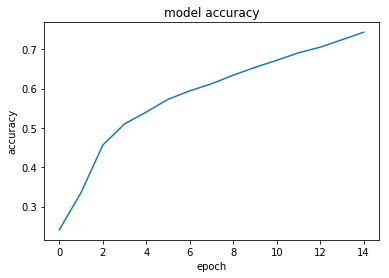

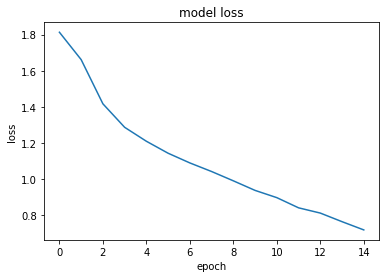

In [17]:
weights = model.get_weights()
np.save('my_model_weights', weights)
plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
test_eval = model.evaluate(test_X_4d, test_Y_one_hot_encoding, verbose =1);
print('batch_size:', batch_size, 'epochs:', epochs)
print('test loss and acc is', test_eval[0], test_eval[1]);

3589/3589 [==============================] - 0s 114us/step
batch_size: 128 epochs: 15
test loss and acc is 1.123697969833102 0.6043466146891082


In [19]:
def get_emotion(indx):
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

In [20]:
for emotion in range(0, 7):
    current_data = test_X_4d[test_Y[:] == emotion]
    current_lable = test_Y_one_hot_encoding[test_Y[:] == emotion]
    scores = model.evaluate(current_data, current_lable, verbose=1)
    print('> Accuracy %.2f%% for <%s>'% (scores[1]*100, get_emotion(emotion)))

491/491 [==============================] - 0s 136us/step
> Accuracy 50.51% for <angry>
55/55 [==============================] - 0s 422us/step
> Accuracy 67.27% for <disgust>
528/528 [==============================] - 0s 136us/step
> Accuracy 27.65% for <fear>
879/879 [==============================] - 0s 125us/step
> Accuracy 82.48% for <happy>
594/594 [==============================] - 0s 134us/step
> Accuracy 48.48% for <sad>
416/416 [==============================] - 0s 111us/step
> Accuracy 75.72% for <surprise>
626/626 [==============================] - 0s 110us/step
> Accuracy 65.50% for <neutral>
